 start!! 
min_x: 0
min_y: 0
max_x: 500
max_y: 500
x_width: 500
y_width: 500
Goal found!
Path len:  515 , Time elapsed:  175.25 sec.; nodes expanded=  16758  with B =  141 Env. size =  500  and |C| =  500


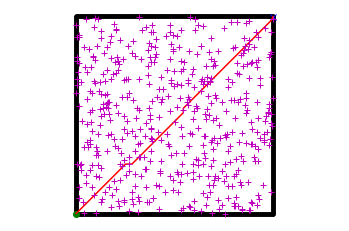

min_x: 0
min_y: 0
max_x: 500
max_y: 500
x_width: 500
y_width: 500
Goal found!
Path len:  536 , Time elapsed:  216.71875 sec.; nodes expanded=  47414  with B =  141 Env. size =  500  and |C| =  500


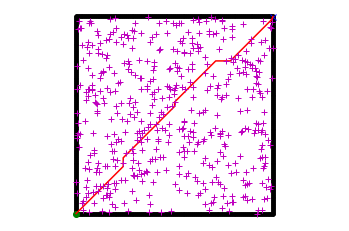

In [9]:
"""

A* grid planning

original authors: Atsushi Sakai(@Atsushi_twi)
        Nikos Kanargias (nkana@tee.gr)
        
modifications: Ayan Dutta (a.dutta@unf.edu)

See Wikipedia article (https://en.wikipedia.org/wiki/A*_search_algorithm)

"""

import math
import random
import time
#import heapq
# from Queue import Queue
# from Queue import PriorityQueue

import matplotlib.pyplot as plt



# class PriorityQueue:
#     def __init__(self):
#         self.elements = []

#     def empty(self):
#         return len(self.elements) == 0

#     def put(self, item, priority):
#         heapq.heappush(self.elements, (item,priority))

#     def get(self):
#         return heapq.heappop(self.elements)

class AStarPlanner:

    def __init__(self, ox, oy, resolution, rr, budget, sc):
        """
        Initialize grid map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y = 0, 0
        self.max_x, self.max_y = 0, 0
        self.obstacle_map = None
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()
        self.calc_obstacle_map(ox, oy)
        self.RC = []
        self.Cx= []
        self.Cy = []
        self.generate_RC(sc) # random charging station location
        self.stationCount = sc # needs to pass the value
        self.budget = budget # needs to pass the value

    class Node:
        def __init__(self, x, y, cost, parent_index, enr):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index
            self.enr = enr

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(
                self.cost) + "," + str(self.parent_index)

    def planning(self, sx, sy, gx, gy,budget):
        """
        A star path search

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1,budget)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1,0)

        open_set = dict()
        closed_set = dict()  #can be improved by using a Priority Queue -- originally, it was dict()
        open_set[self.calc_grid_index(start_node)] = start_node
        #open_set.put(start_node, 0)
        
        #cost_so_far = {start_node: 0}
        #came_from = {start_node: None}
        #print(self.RC)
        
        while 1:
            if len(open_set)==0:
                #print("Open set is empty..")
                break

            c_id = min(
                open_set,
                key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node,
                                                                     open_set[
                                                                         o]))
            current = open_set[c_id]
            #current = open_set.get() # using a PQ now...
            if current.x == goal_node.x and current.y == goal_node.y:
                print("Goal found!")
                #came_from[goal_node] = came_from[current]
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current
            #closed_set.append(current)
            
            if current.enr < 0:
                print("Why explored a node with Br < 0? ",current.x,current.y)
                  
            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                new_enr = current.enr -1
                node = self.Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2], c_id,new_enr)
                n_id = self.calc_grid_index(node)
                #new_cost = cost_so_far[current] + self.motion[i][2]
                node.enr = new_enr
                
                # if the remaining budget < 0, do not add it to OPEN
                if [node.x,node.y] in self.RC:
                    node.enr = node.enr+budget
                if node.enr < 0:
                    continue
                
                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue
                    
                # adding/updating to open_set business    
                if n_id not in open_set or open_set[n_id].cost > node.cost:
                    open_set[n_id] = node  # discovered a new node
#                     cost_so_far[node] = new_cost
#                     priority = new_cost + self.calc_heuristic(goal_node,node)
#                     open_set.put(node, priority)
#                     came_from[node] = current


        rx, ry = self.calc_final_path(goal_node, closed_set)

        return rx, ry, self.Cx, self.Cy, len(closed_set)

#     def calc_final_path(self, goal_node, closed_set):
#        # generate final course
#         rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
#             self.calc_grid_position(goal_node.y, self.min_y)]
#         current = came_from[goal_node]
#         while current != None:
#             #n = closed_set[parent_index]
#             if n.enr < 0:
#                 print("Constraint VIOLATED!")
#             #else:
#                 #print(n.enr)
#             rx.append(self.calc_grid_position(n.x, self.min_x))
#             ry.append(self.calc_grid_position(n.y, self.min_y))
#             #parent_index = n.parent_index
#             current = came_from[current]

#         return rx, ry
    
    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        #print("total node expanded (in the CLOSE set): ",len(closed_set))
        while parent_index != -1:
            n = closed_set[parent_index]
            if n.enr < 0:
                print("Constraint VIOLATED!")
#             else: 
#                 if [n.x,n.y] not in self.RC:
#                     print(n.enr)
#                 else:
#                     print([n.x,n.y])    
                
            
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry

    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def calc_grid_position(self, index, min_position):
        """
        calc grid position

        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.x][node.y]:
            return False

        return True
    
    def generate_RC(self,stationCount):
        #print(self.min_x,self.max_x)
        while len(self.RC) < stationCount:
            rx = random.randint(self.min_x, self.max_x)
            ry = random.randint(self.min_y, self.max_y)
            rc = [rx,ry]
            rc_node=self.Node(self.calc_xy_index(rx, self.min_x),
                               self.calc_xy_index(ry, self.min_y), 0.0, -1,0)
            # collision check
            if self.verify_node(rc_node) and [rc_node.x,rc_node.y] not in self.RC:
                self.RC.append([rc_node.x,rc_node.y])
                self.Cx.append(self.calc_grid_position(rc_node.x, self.min_x))
                self.Cy.append(self.calc_grid_position(rc_node.y, self.min_y))
                #self.RCxy.append(rc)
                #print(rc_node.x,rc_node.y)
        
        
    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        self.obstacle_map = [[False for _ in range(self.y_width)]
                             for _ in range(self.x_width)]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion

def main():
    #print(__file__ + " start!!")
    print(" start!! ")
    
    # parameters
    b = 20 # k% of the diaginal 
    size = 500 # square environment: n * n
    budget = round(b/100 * (size * (2 ** (1/2)))) 
    c = 0.2 # m% of all the nodes
    rcCount = round(size * size * c/100) 
    #print(rcCount," ",budget," ",size)
    run = 0

    #create a new text file for data collection w/ this setting
    fname = "BCA_s"+str(size)+"_B"+str(b)+"_C"+str(c)+".txt"
    file = open(fname, "a")  # append mode
    while run<2:
    
        # start and goal position
        sx = 1.0  # [m]
        sy = 1.0  # [m]
        gx = size-1 # [m]
        gy = size-1  # [m]
        grid_size = 1.0  # [m]
        robot_radius = 0.75  # [m]

        # set obstacle positions
        ox, oy = [], []
#         for i in range(-10, 60):
#             ox.append(i)
#             oy.append(-10.0)
#         for i in range(-10, 60):
#             ox.append(60.0)
#             oy.append(i)
#         for i in range(-10, 61):
#             ox.append(i)
#             oy.append(60.0)
#         for i in range(-10, 61):
#             ox.append(-10.0)
#             oy.append(i)
#         for i in range(-10, 40):
#             ox.append(20.0)
#             oy.append(i)
#         for i in range(0, 40):
#             ox.append(40.0)
#             oy.append(60.0 - i)
        
        for i in range(0, size):
            ox.append(i)
            oy.append(0)
        for i in range(0, size):
            ox.append(size)
            oy.append(i)
        for i in range(0, size+1):
            ox.append(i)
            oy.append(size)
        for i in range(0, size+1):
            ox.append(0)
            oy.append(i)

        startT= time.process_time()

        # the object is created and the path planning function is called next
        a_star = AStarPlanner(ox, oy, grid_size, robot_radius,budget,rcCount)
        rx, ry, Cx, Cy, nodes_exp = a_star.planning(sx, sy, gx, gy,budget)

        elapsedT = time.process_time() - startT

        #x = [x for x, y in RC]
        #y = [y for x, y in RC]
        show_animation = True

        if len(rx) <= 2:
            show_animation=False
        else:
            run=run+1
            print("Path len: ",len(rx),", Time elapsed: ",elapsedT,"sec.; nodes expanded= ", nodes_exp ," with B = ",budget, "Env. size = ", size, " and |C| = ",rcCount)
            data = str(len(rx)) + " " + str(elapsedT) + " " + str(nodes_exp) + "\n"
            file.write(data)
        
        if run==5:
            file.close()
    
        if show_animation:  # pragma: no cover
            plt.plot(ox, oy, ".k")
            plt.plot(sx, sy, "og")
            plt.plot(gx, gy, "xb")
            plt.grid(True)
            plt.axis("equal")
            plt.axis('off')

        # plot the path and save the picture
        if show_animation:  # pragma: no cover
            plt.plot(rx, ry, "-r")
            plt.plot(Cx, Cy, "+m")
            #plt.savefig("Desktop/boundedcostECA.png", dpi=300,bbox_inches='tight')
            plt.pause(0.001)
            plt.show()
        
if __name__ == '__main__':
    main()
        